In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from rich import print

sns.set_theme(
    context='notebook', 
    font='Linux Libertine O',
    rc={'figure.figsize':(4,3), 'mathtext.fontset': 'stix',},
)

deep = sns.color_palette('deep')
palette = ([deep[2], deep[1], deep[3]])
color = deep[0]

# Part 1: Exploratory Analysis of Lung Cancer Data

The lung cancer dataset contains data of 1000 patients with 23 features and 1 target variable (the level of cancer development).

The goal is to study the relationship between the features and the target variable.

We first load the data and clean it. We remove the rows with missing values.

In [2]:
df = pd.read_csv('datasets/Original.csv', index_col=0)
df = df.drop(columns=['Patient Id'])
df = df.astype({'Gender': 'category'})
df = df.dropna()
df

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
index,,,,,,,,,,,,,,,,,,,,,
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,Low
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,High
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,High
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,44,1,6,7,7,7,7,6,7,7,...,5,3,2,7,8,2,4,5,3,High
996,37,2,6,8,7,7,7,6,7,7,...,9,6,5,7,2,4,3,1,4,High
997,25,2,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,High


We categorize features into 4 groups:
- **Environmental** features: features that are related to the environment of the patient
- **Lifestyle**: features that are related to the lifestyle of the patient
- **Physical**: features that are related to the physical condition of the patient
- **Symptoms**: features that are related to the symptoms of the patient

In [3]:
feature_groups = {
    'Environmental': ['Air Pollution', 'OccuPational Hazards', 'Passive Smoker'],
    'Lifestyle': ['Alcohol use', 'Balanced Diet', 'Smoking'],
    'Physical': ['Age', 'Gender', 'Dust Allergy', 'Genetic Risk', 'chronic Lung Disease', 'Obesity'],
    'Symptoms': ['Chest Pain', 'Coughing of Blood', 'Fatigue', 'Weight Loss', 'Shortness of Breath', 'Wheezing', 
            'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Frequent Cold', 'Dry Cough', 'Snoring']
}

feature2group = {feature: group for group, features in feature_groups.items() for feature in features}

for group, features in feature_groups.items():
    print(group, ':\n', features)

Environmental :

['Air Pollution', 'OccuPational Hazards', 'Passive Smoker']

Lifestyle :

['Alcohol use', 'Balanced Diet', 'Smoking']

Physical :

['Age', 'Gender', 'Dust Allergy', 'Genetic Risk', 'chronic Lung Disease', 'Obesity']

Symptoms :

[
    'Chest Pain',
    'Coughing of Blood',
    'Fatigue',
    'Weight Loss',
    'Shortness of Breath',
    'Wheezing',
    'Swallowing Difficulty',
    'Clubbing of Finger Nails',
    'Frequent Cold',
    'Dry Cough',
    'Snoring'
]

Let's look at some basic descriptive statistics of the data.

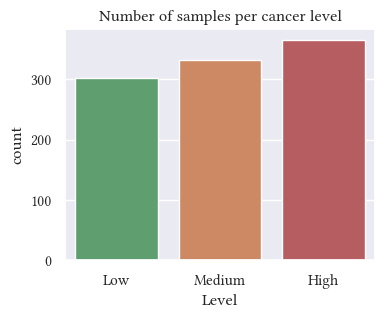

In [4]:
ax = sns.countplot(data=df, x='Level', palette=palette)
_ = ax.set_title('Number of samples per cancer level')

The dataset is sufficiently balanced. 

Let's look at the gender distribution.

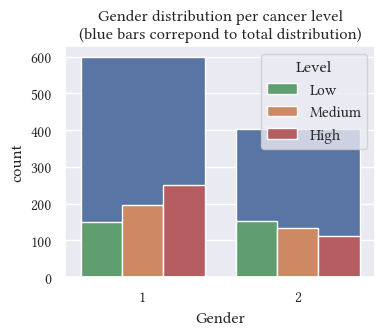

In [13]:
ax = sns.countplot(data=df, x='Gender', color=color)
ax = sns.countplot(data=df, x='Gender', hue='Level', palette=palette, ax=ax)
_ = ax.set_title('Gender distribution per cancer level\n(blue bars correpond to total distribution)')

Gender 1 group has around 200 samples more than Gender 2. Also, Gender 1 has a higher level of cancer development than Gender 2.

Now, let's look at Age distribution.

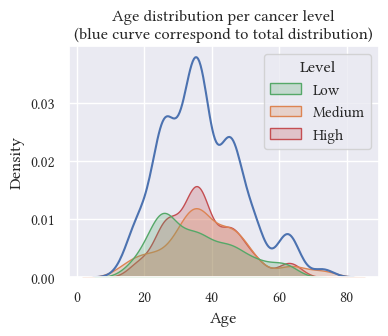

In [9]:
ax = sns.kdeplot(data=df, x='Age', fill=False, color=color)
ax = sns.kdeplot(data=df, x='Age', hue='Level', fill=True, palette=palette, ax=ax)
_ = ax.set_title('Age distribution per cancer level\n(blue curve correspond to total distribution)')

We see that there's no significant difference in age distribution within the three groups.

Now, we look at the distribution of other features.

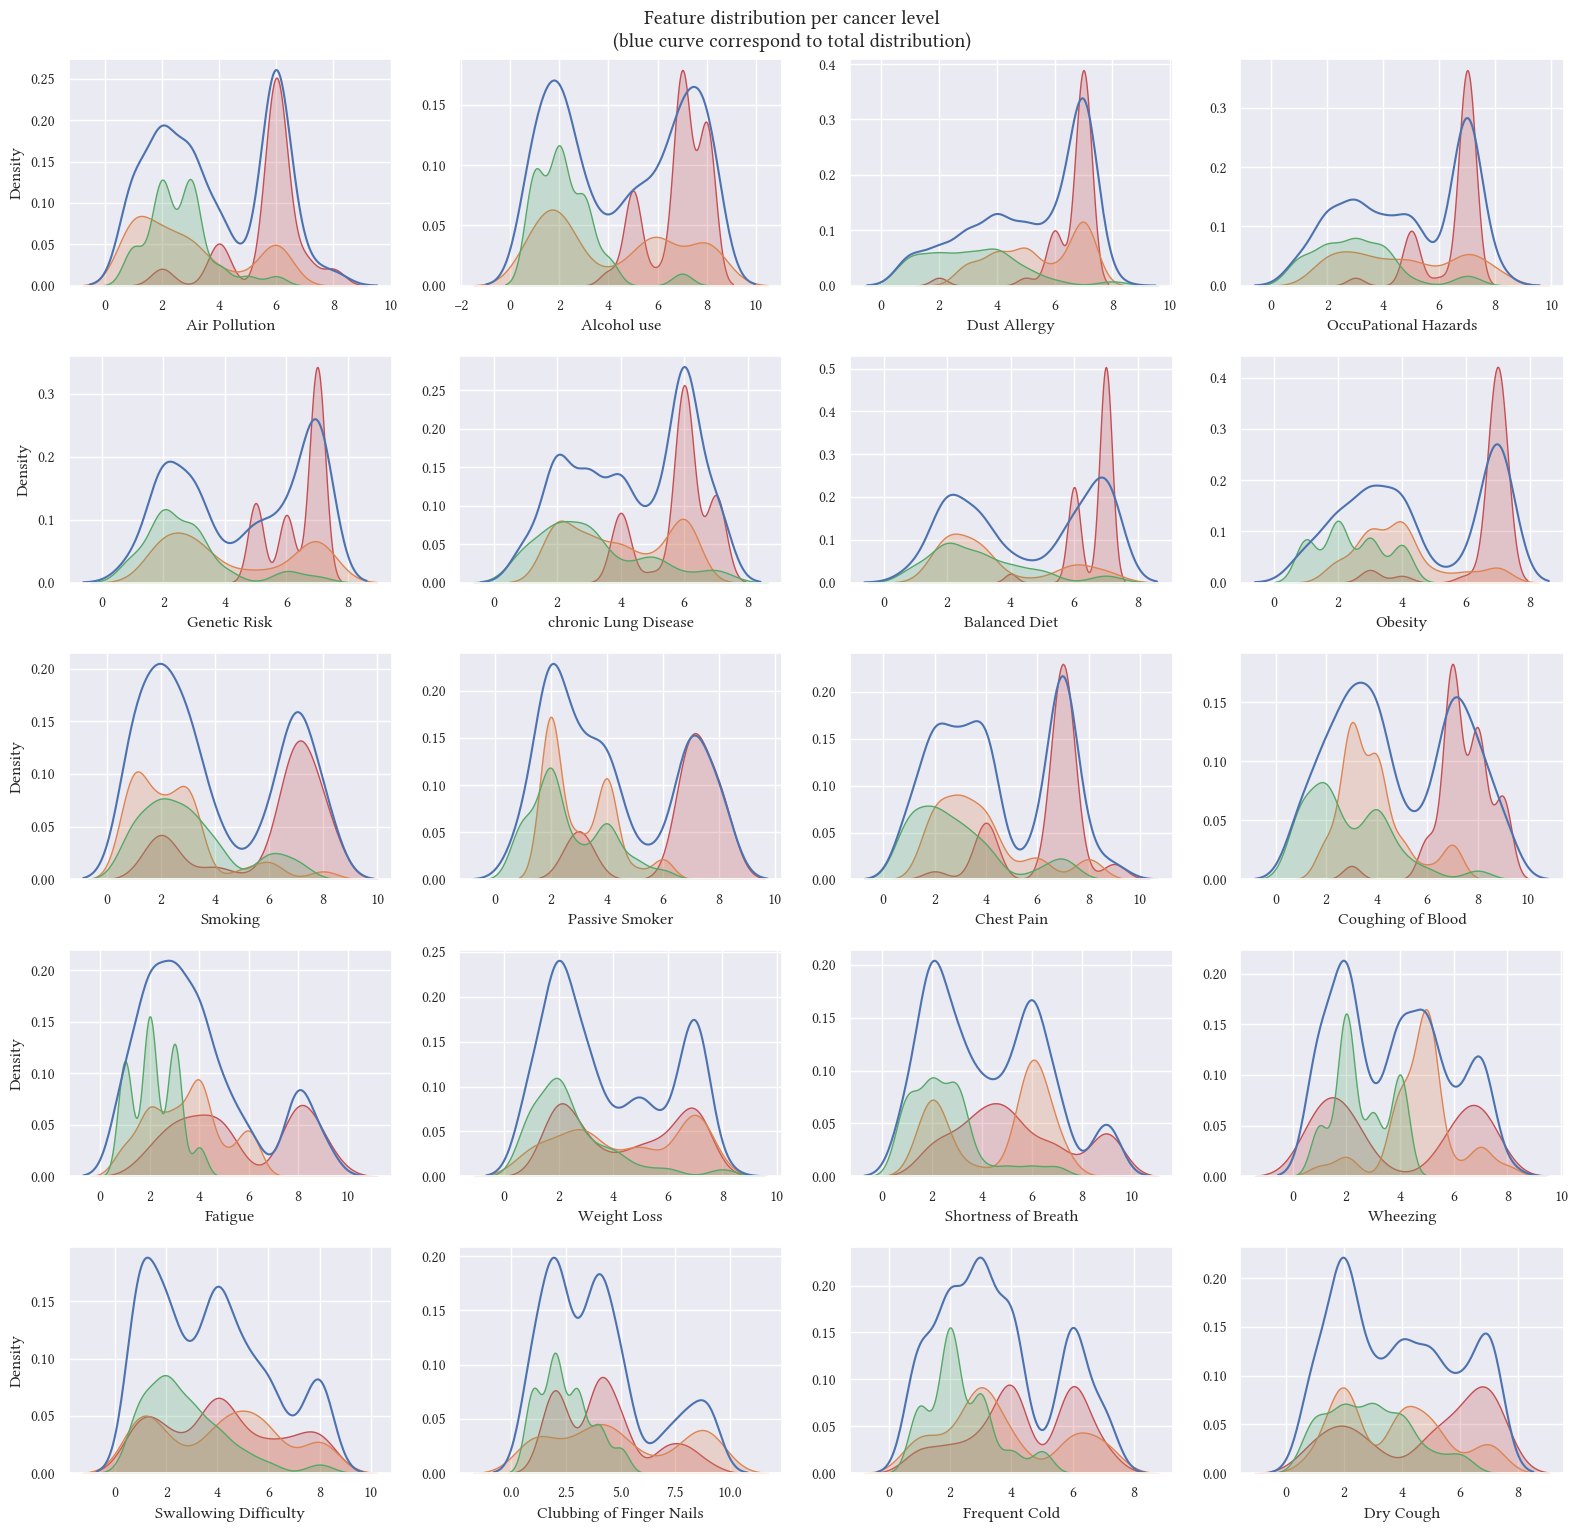

In [11]:
fig, axes = plt.subplots(5, 4, figsize=(16, 15))
for i, col in enumerate(df.columns[2:-2]):
    ax = axes[i//4, i%4]
    sns.kdeplot(data=df, x=col, fill=False, color=color, ax=ax)
    sns.kdeplot(data=df, x=col, hue='Level', fill=True, palette=palette, ax=ax, legend=False)
    if i%4 != 0:
        ax.set_ylabel(None)

fig.tight_layout()
_ = fig.suptitle('Feature distribution per cancer level\n(blue curve correspond to total distribution)', y=1.02)

## Data Visualization with T-SNE

/remote/idiap.svm/temp.social02/sajadmanesh/conda/envs/roche/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<AxesSubplot: xlabel='x', ylabel='y'>

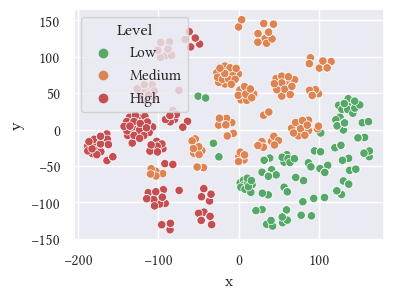

In [12]:
X = df.drop(columns=['Level']).values
X = MinMaxScaler().fit_transform(X)
X = TSNE(n_components=2, perplexity=50, learning_rate='auto', init='pca', n_jobs=-1).fit_transform(X)
df_tsne = pd.DataFrame(X, columns=['x', 'y'])
df_tsne['Level'] = df['Level']
sns.scatterplot(data=df_tsne, x='x', y='y', hue='Level', palette=palette)

## Correlation Analysis

<AxesSubplot: >

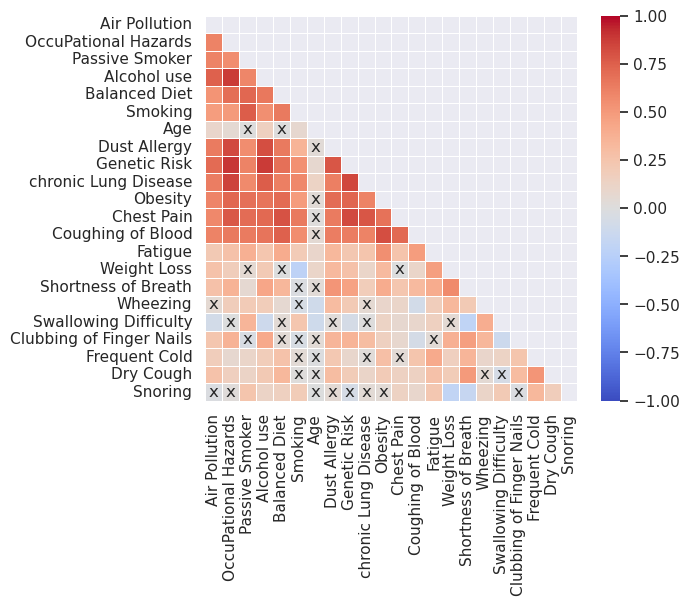

In [33]:
method = 'pearson'
alpha = 0.05
corr_method = {
    'pearson': pearsonr,
    'kendall': kendalltau,
    'spearman': spearmanr
}[method]
df_temp = df[sum(feature_groups.values(), [])]
df_corr = df_temp.corr(method='pearson', numeric_only=True)
pval = (df_temp.drop(columns=['Gender']).corr(method=lambda x, y: corr_method(x, y)[1]) - np.eye(len(df.columns) - 2))
annot = pval.applymap(lambda x: '' if x < alpha else 'x')
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_corr, vmin=-1, vmax=1, cmap='coolwarm', mask=mask, linewidths=.5, annot=annot, fmt='', ax=ax)

## Effect of Feature Groups on Cancer Level Prediction Accuracy

In [14]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

label_encoder = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

y = df['Level'].map(label_encoder).values
df_acc = pd.DataFrame(columns=['Feature Group', 'Accuracy', 'Trial'])
subgroups = [subset for L in range(1, len(feature_groups) + 1) for subset in itertools.combinations(feature_groups, L)]
inner_progress = tqdm(subgroups, position=0, leave=True)

for subset in inner_progress:
    inner_progress.set_description(f'Feature Group: {" + ".join(subset)}')
    for trial in tqdm(range(10), position=1, leave=False):
        features = sum([feature_groups[group] for group in subset], [])
        X = df[features].values
        X = MinMaxScaler().fit_transform(X)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=trial)
        model = MLPClassifier(hidden_layer_sizes=16, activation='relu', batch_size=32, alpha=0, learning_rate_init=0.001, max_iter=100, random_state=trial)
        model.fit(X_train, y_train)
        acc = model.score(X_val, y_val)
        df_acc = pd.concat([df_acc, pd.DataFrame({'Feature Group': ' + '.join(subset), 'Accuracy': acc, 'Trial': 0}, index=[0])], ignore_index=True)
            
df_acc_agg = df_acc.groupby('Feature Group', sort=False)['Accuracy'].agg(['mean', 'std'])#.sort_values('mean', key=lambda col: col.map(lambda x: ), ascending=False)
df_acc_agg['key'] = df_acc_agg.reset_index().apply(lambda row: row['Feature Group'].count('+') * 100 + row['mean'], axis=1).values
df_acc_agg = df_acc_agg.sort_values('key', ascending=True).drop(columns='key')
df_acc_agg['Accuracy'] = df_acc_agg['mean'].map(lambda x: f'{x:.2f} ± {df_acc_agg.loc[df_acc_agg["mean"] == x, "std"].values[0]:.2f}')
df_acc_agg = df_acc_agg.drop(columns=['mean', 'std'])
df_acc_agg

Feature Group: Environmental + Lifestyle + Physical + Symptoms: 100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


,Accuracy
Feature Group,
Lifestyle,0.69 ± 0.07
Environmental,0.74 ± 0.03
Physical,0.81 ± 0.04
Symptoms,0.97 ± 0.01
Environmental + Lifestyle,0.82 ± 0.03
Lifestyle + Physical,0.87 ± 0.03
Environmental + Physical,0.89 ± 0.03
Lifestyle + Symptoms,0.98 ± 0.01
Environmental + Symptoms,0.99 ± 0.01


## Importance of Features for Cancer Level Prediction

100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


Validation Accuracy: 1.00 ± 0.00

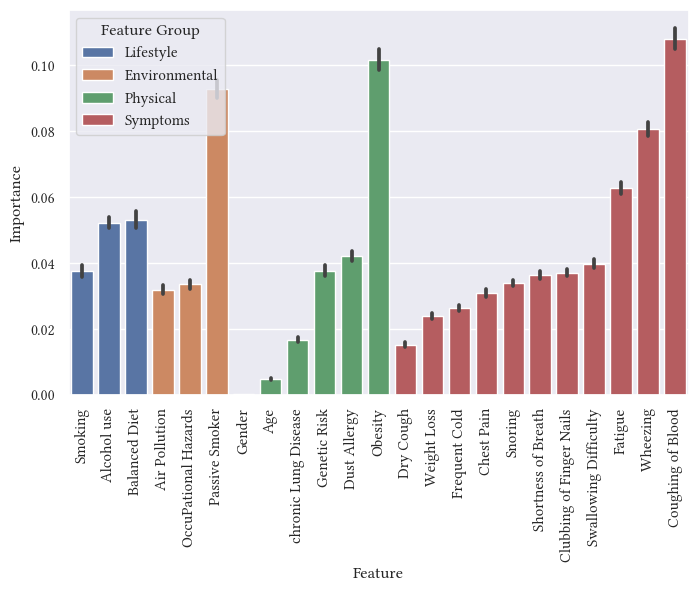

In [16]:
label_encoder = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

y = df['Level'].map(label_encoder).values
X = df.drop(columns=['Level']).values

acc_list = []
df_features = pd.DataFrame(columns=['Feature', 'Importance', 'Trial'])

for trial in tqdm(range(100)):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=trial)
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=trial)
    model.fit(X_train, y_train)
    acc = model.score(X_val, y_val)
    acc_list.append(acc)
    df_run = pd.DataFrame({'Feature': df.drop(columns=['Level']).columns, 'Importance': model.feature_importances_})
    df_run['Trial'] = trial
    df_features = pd.concat([df_features, df_run], ignore_index=True)

print(f'Validation Accuracy: {np.mean(acc_list):.2f} ± {np.std(acc_list):.2f}')

df_features['Feature Group'] = df_features['Feature'].map(lambda x: [group for group in feature_groups if x in feature_groups[group]][0])
df_temp = df_features.groupby('Feature')[['Importance']].mean()
df_temp['Feature Group'] = df_temp.index.map(lambda x: [group for group in feature_groups if x in feature_groups[group]][0])
df_temp = df_temp.sort_values('Importance')
df_temp = df_temp.sort_values('Feature Group', kind='mergesort', key=lambda col: df_temp.groupby('Feature Group')[['Importance']].max().loc[col, 'Importance'])
hue_order = df_temp.groupby('Feature Group')['Importance'].max().sort_values().index

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df_features, hue='Feature Group', y='Importance', x='Feature', order=df_temp.index, hue_order=hue_order, dodge=False, ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [17]:
best_features = df_features.groupby(['Feature Group', 'Feature'])[['Importance']].mean().reset_index(level=0).groupby('Feature Group')['Importance'].idxmax().values
best_features

label_encoder = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

y = df['Level'].map(label_encoder).values
X = df[best_features].values

acc_list = []

for trial in tqdm(range(100)):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=trial)
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=trial)
    model.fit(X_train, y_train)
    acc = model.score(X_val, y_val)
    acc_list.append(acc)

print(f'Validation Accuracy using most important features of each group: {np.mean(acc_list):.2f} ± {np.std(acc_list):.2f}')

100%|██████████| 100/100 [00:05<00:00, 17.85it/s]


Validation Accuracy using most important features of each group: 0.96 ± 0.01

# Importance of Features for Cancer Level Prediction within Age Subgroups

In [18]:
median_age = df['Age'].quantile()
df_young = df[df['Age'] <= median_age]
df_old = df[df['Age'] > median_age]

label_encoder = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

df_features = pd.DataFrame(columns=['Feature', 'Importance', 'Age Group', 'Trial'])

for df_temp in [df_young, df_old]:

    y = df_temp['Level'].map(label_encoder).values
    X = df_temp.drop(columns=['Level']).values

    acc_list = []

    for trial in tqdm(range(100)):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=trial)
        model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=trial)
        model.fit(X_train, y_train)
        acc = model.score(X_val, y_val)
        acc_list.append(acc)
        df_run = pd.DataFrame({'Feature': df_temp.drop(columns=['Level']).columns, 'Importance': model.feature_importances_})
        df_run['Trial'] = trial
        df_run['Age Group'] = 'Young' if df_temp is df_young else 'Old'
        df_features = pd.concat([df_features, df_run], ignore_index=True)

    print(f"Validation Accuracy for {'Young' if df_temp is df_young else 'Old'} group: {np.mean(acc_list):.2f} ± {np.std(acc_list):.2f}")

100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


Validation Accuracy for Young group: 1.00 ± 0.00

100%|██████████| 100/100 [00:05<00:00, 17.95it/s]


Validation Accuracy for Old group: 1.00 ± 0.00

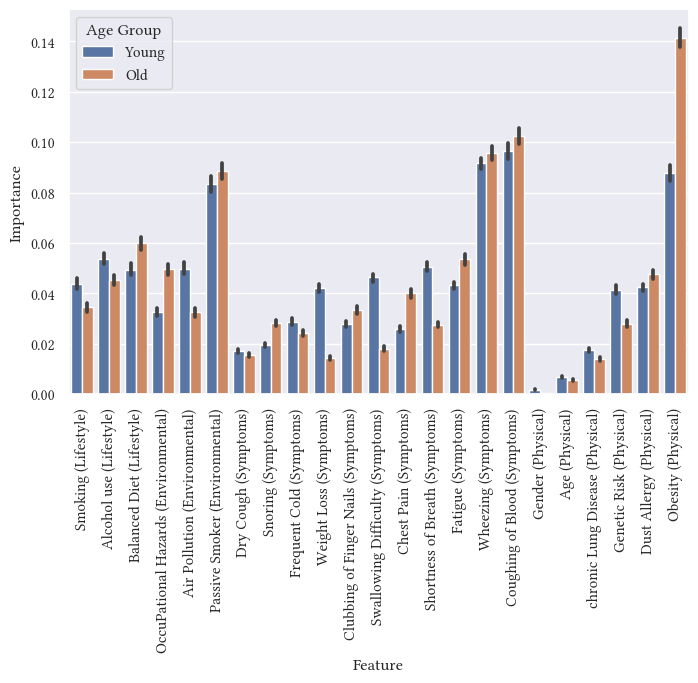

In [19]:
df_features['Feature Group'] = df_features['Feature'].map(lambda x: [group for group in feature_groups if x in feature_groups[group]][0])
df_temp = df_features.groupby('Feature')[['Importance']].mean()
df_temp['Feature Group'] = df_temp.index.map(lambda x: [group for group in feature_groups if x in feature_groups[group]][0])
df_temp = df_temp.sort_values('Importance')
df_temp = df_temp.sort_values('Feature Group', kind='mergesort', key=lambda col: df_temp.groupby('Feature Group')[['Importance']].max().loc[col, 'Importance'])
x_order = df_temp.index

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df_features, hue='Age Group', y='Importance', x='Feature', order=df_temp.index, ax=ax)
xticklabels = list(map(lambda x: f'{x} ({[group for group in feature_groups if x in feature_groups[group]][0]})', x_order))
_ = ax.set_xticklabels(xticklabels, rotation=90)

# Part 2: Anonyzation of Lung Cancer Data

## Level of Anonymity based on K-Anonymity

In [26]:
df_orig = pd.read_csv('datasets/Original.csv')
quasi_identifiers = ['Age', 'Gender']
k = df_orig.groupby(quasi_identifiers).size().min()
print('the original dataset is k-anonymized with k={}'.format(k))

the original dataset is k-anonymized with k=1

In [20]:
df_priv = pd.read_csv('datasets/Anonymised.csv')
quasi_identifiers = ['Age', 'Gender']
k = df_priv.groupby(quasi_identifiers).size().min()
print('the original dataset is k-anonymized with k={}'.format(k))

the original dataset is k-anonymized with k=3

## Data Utility

We use the precision metric defined in [1] to evaluate the usefulness of the data. Given a dataset $D$ with $N$ records, each having $K$ attributes, the precision metric is defined as:  

$Prec(D) = 1 - \frac{1}{N\cdot K}\sum_{j=1}^{K}\sum_{i=1}^{N}\frac{U_{i,j}-L_{i,j}}{U_{j}-L_{j}}$,

where $U_{i,j}$ and $L_{i,j}$ are the upper and lower bounds of the $j$th attribute of the $i$th record, respectively. $U_{j}$ and $L_{j}$ are the upper and lower bounds of the $j$th attribute of the entire dataset, respectively. The precision metric is a value between 0 and 1, where 1 indicates that the information is perfectly preserved, while a precision of 0 indicates total information loss.

[1] Nergiz, M.E. and Clifton, C., 2007. Thoughts on k-anonymization. Data & Knowledge Engineering, 63(3), pp.622-645.

In [42]:
bounds = df_priv['Age'].apply(lambda x: tuple(map(float, x[1:-1].split(','))))
lower = min(map(min, bounds))
upper = max(map(max, bounds))

precision = 1 - df_priv['Age'].apply(lambda bound: (float(bound[1:-1].split(',')[1]) - float(bound[1:-1].split(',')[0])) / (upper - lower)).mean()
print('the precision of the anonymised dataset is {:.2f}'.format(precision))

the precision of the anonymised dataset is 0.80